In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


In [91]:
df = pd.read_csv("StudentsPerformance.csv")

In [92]:
df.head(5)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [93]:
df.shape

(1000, 8)

In [94]:
print(df.isnull().sum())

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


In [95]:
print(df.duplicated().sum())


0


In [96]:

numeric_cols = ['math score', 'reading score', 'writing score']

df_clean = df.copy()
for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
   
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

print("Outliers removed successfully!")
print(f"Original shape: {df.shape}")
print(f"New shape: {df_clean.shape}")


Outliers removed successfully!
Original shape: (1000, 8)
New shape: (986, 8)


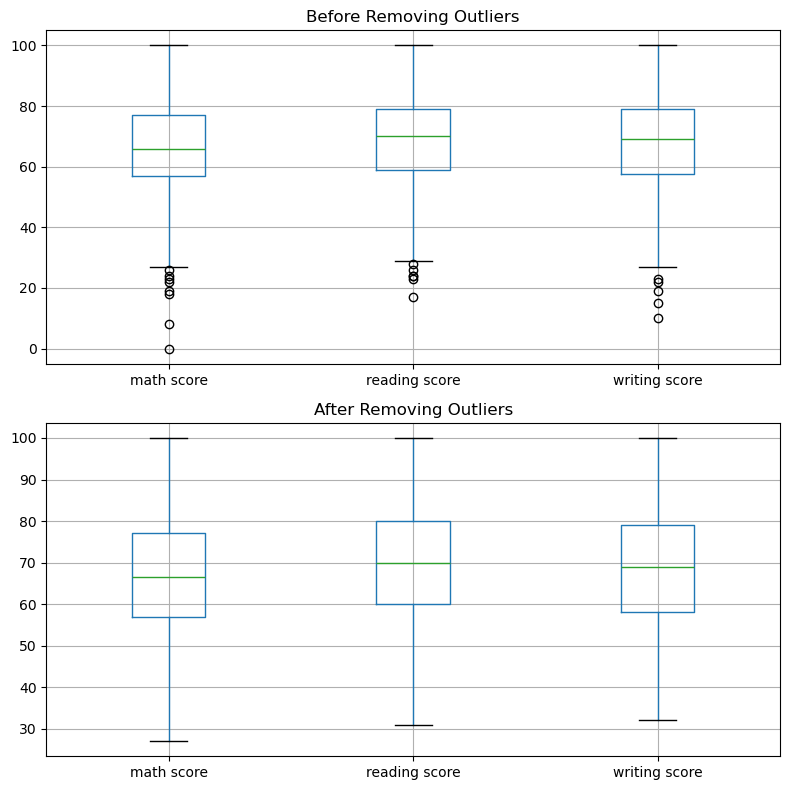

In [97]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(8,8))
df[numeric_cols].boxplot(ax=axes[0])
axes[0].set_title("Before Removing Outliers")

df_clean[numeric_cols].boxplot(ax=axes[1])
axes[1].set_title("After Removing Outliers")

plt.tight_layout()
plt.show()


Skewness of numerical columns:
 math score      -0.278935
reading score   -0.259105
writing score   -0.289444
dtype: float64


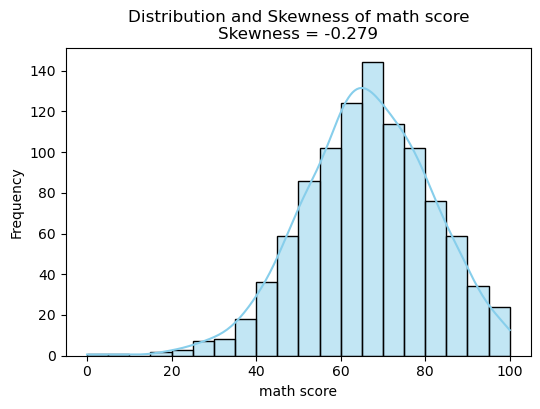

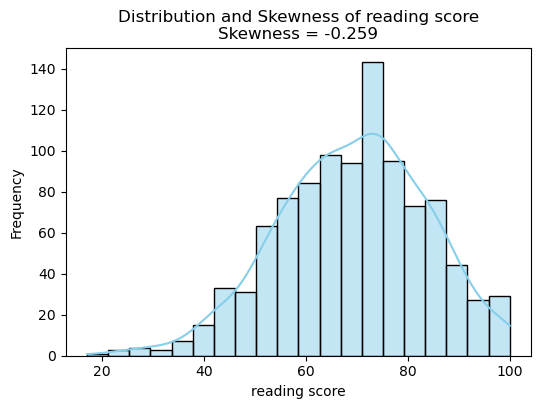

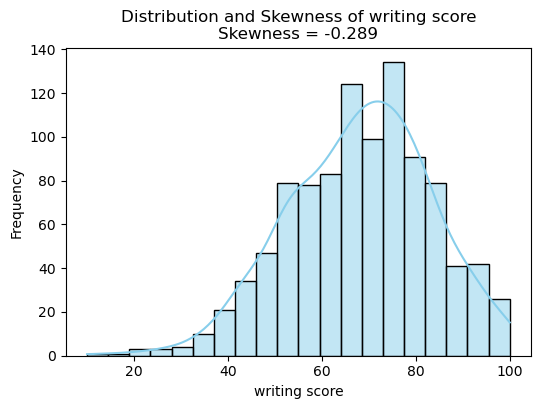

In [98]:

columns = ['math score', 'reading score', 'writing score']

skew_values = df[columns].skew()
print("Skewness of numerical columns:\n", skew_values)

for col in columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, color='skyblue', bins=20)
    plt.title(f'Distribution and Skewness of {col}\nSkewness = {skew_values[col]:.3f}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


In [99]:
from sklearn.preprocessing import LabelEncoder

cols_to_encode = ['race/ethnicity', 'lunch']  # only encode these with LabelEncoder
le = LabelEncoder()

for col in cols_to_encode:
    df[col] = le.fit_transform(df[col])

# 1 = completed, 0 = none
df['test preparation course'] = df['test preparation course'].map({'none': 0, 'completed': 1})


In [100]:
df.head(5)  

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,1,bachelor's degree,1,0,72,72,74
1,female,2,some college,1,1,69,90,88
2,female,1,master's degree,1,0,90,95,93
3,male,0,associate's degree,0,0,47,57,44
4,male,2,some college,1,0,76,78,75


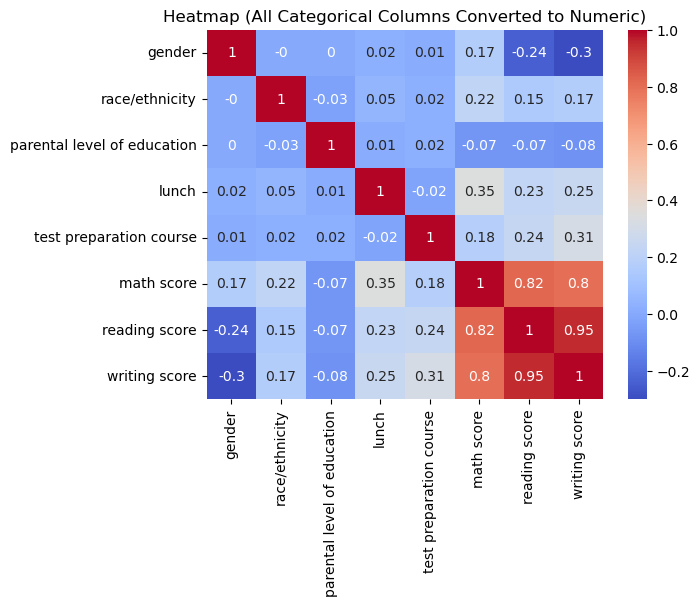

In [101]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category').cat.codes

corr = df.corr().round(2)

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Heatmap (All Categorical Columns Converted to Numeric)")
plt.show()

In [105]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

df = pd.read_csv("StudentsPerformance.csv")

X = df[[
    'gender',
    'race/ethnicity',
    'parental level of education',
    'lunch',
    'test preparation course',
    'reading score',
    'writing score'
]]
y = df['math score']

categorical_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(drop='first'), categorical_cols)
], remainder='passthrough')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

model = LinearRegression()
model.fit(X_train_enc, y_train)

y_pred = model.predict(X_test_enc)
r2 = model.score(X_test_enc, y_test)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.2f}")
print(f"Intercept: {model.intercept_:.2f}")

feature_names = preprocessor.get_feature_names_out()
coefficients = model.coef_

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

student_features = [
    'encoder__race/ethnicity_group B',
    "encoder__parental level of education_bachelor's degree",
    'encoder__lunch_standard',
    'encoder__test preparation course_completed',
    'remainder__reading score',
    'remainder__writing score'
]
student_coef = coef_df[coef_df['Feature'].isin(student_features)].reset_index(drop=True)
print("\nCoefficients for the new student's features:\n")
print(student_coef)

new_student = pd.DataFrame({
    'gender': ['female'],
    'race/ethnicity': ['group B'],
    'parental level of education': ["bachelor's degree"],
    'lunch': ['standard'],
    'test preparation course': ['completed'],
    'reading score': [80],
    'writing score': [78]
})

new_student_enc = preprocessor.transform(new_student)
predicted_score = model.predict(new_student_enc)[0]
print(f"\nPredicted Math Score for New Student: {predicted_score:.2f}")


R² Score: 0.8804
MSE: 29.10
Intercept: -10.91

Coefficients for the new student's features:

                                             Feature  Coefficient
0                    encoder__race/ethnicity_group B     0.359323
1  encoder__parental level of education_bachelor'...    -0.716901
2                            encoder__lunch_standard     3.510075
3                           remainder__reading score     0.236023
4                           remainder__writing score     0.724148

Predicted Math Score for New Student: 67.61


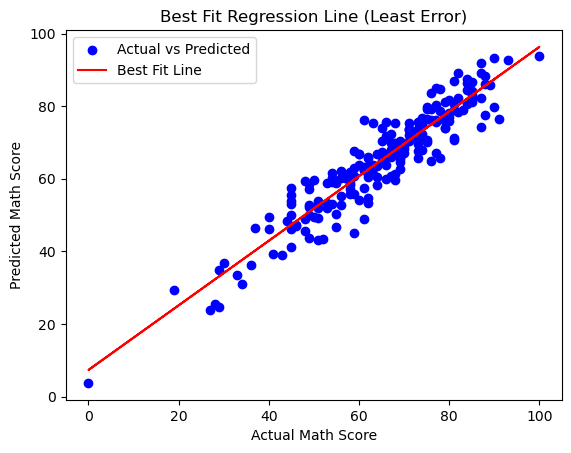

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(X_test_enc)

plt.scatter(y_test, y_pred, color='blue', label='Actual vs Predicted')

m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m * y_test + b, color='red', label='Best Fit Line')
plt.xlabel("Actual Math Score")
plt.ylabel("Predicted Math Score")
plt.title("Best Fit Regression Line (Least Error)")
plt.legend()
plt.show()
